in this notebook we:
* stage 5 - rescaled images, no further downsizing

In [1]:
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

import wandb
from wandb.fastai import WandbCallback

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import configparser

from functions_wandb import *

In [2]:
%matplotlib inline

In [3]:
wandb.init(project="gabon")

W&B Run: https://app.wandb.ai/jedrzej/gabon/runs/6k0sxms1

In [4]:
# PATH_TO_IMG = Path("/data_rescaled")

# PATH_TO_MAIN = Path("/home/jupyter/")
# PATH_TO_TRAIN_DF = PATH_TO_MAIN / "inspect_data_split_validation"
# PATH_TO_MODELS = PATH_TO_MAIN / "training" / "saved_models"
# PATH_TO_CONFIG = PATH_TO_MAIN / "config"

# CONFIG = configparser.ConfigParser()
# CONFIG.read(PATH_TO_CONFIG / "neptune.ini")

In [5]:
df = pd.read_csv(PATH_TO_TRAIN_DF / "train_valid_df.csv")

classes = df.species.unique()
print(len(classes)) # no "Mammal_Other"
classes

28


array(['Human', 'Blank', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey',
       'Duiker_Red', 'Civet_African_Palm', 'Squirrel', 'Duiker_Blue', 'Bird', 'Mongoose_Black_Footed', 'Rodent',
       'Duiker_Yellow_Backed', 'Genet', 'Chimpanzee', 'Gorilla', 'Mongoose', 'Porcupine_Brush_Tailed', 'Pangolin',
       'Mandrillus', 'Chevrotain_Water', 'Cat_Golden', 'Rat_Giant', 'Guineafowl_Crested', 'Guineafowl_Black',
       'Rail_Nkulengu'], dtype=object)

In [6]:
len(df.uniqueName)

347120

In [7]:
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [8]:
df["uniqueName"] = df.uniqueName.apply(lambda x: "resc_" + x)
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,resc_0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,resc_0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,resc_0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,resc_0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,resc_0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [9]:
%%time
data = get_training_data(df, (384, 512), batch_size=32)#, partial_pct=0.01)

CPU times: user 2.52 s, sys: 232 ms, total: 2.75 s
Wall time: 1.84 s


CPU times: user 4.73 s, sys: 1.23 s, total: 5.96 s
Wall time: 4.61 s


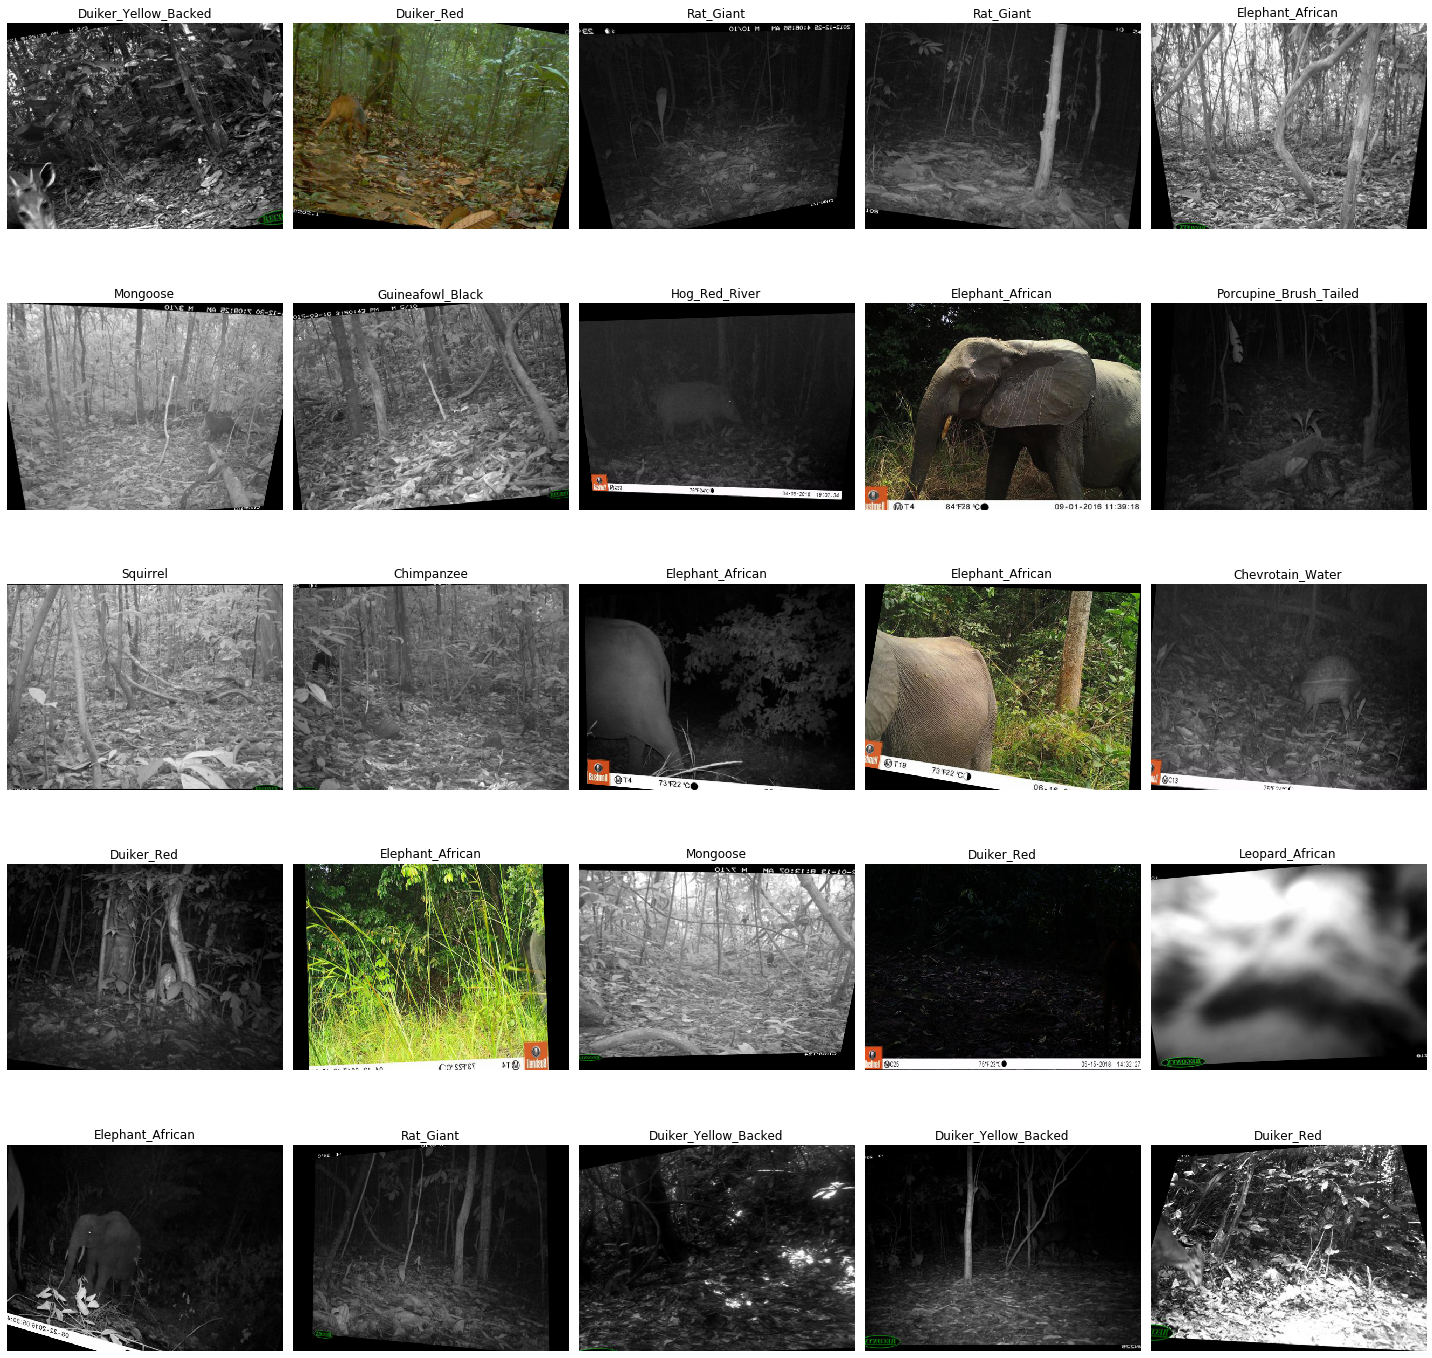

In [10]:
%%time
data.show_batch()

# Stage 5

In [11]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage4-5epochs-192_256-rescaled");

In [12]:
learn.freeze()

In [13]:
%%time
run_find_lr(learn, "stage5-2epochs-384_512-rescaled")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/opt/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



CPU times: user 14.6 s, sys: 5.56 s, total: 20.1 s
Wall time: 39.9 s


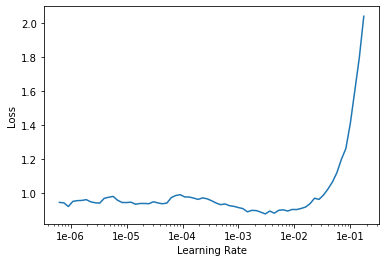

In [14]:
learn.recorder.plot()

In [15]:
lr = 1e-4 * 5
n_epochs =  2

In [16]:
%%time
run_training(learn, "stage5-2epochs-384_512-rescaled", lr=lr, n_epochs=n_epochs)

epoch,train_loss,valid_loss,accuracy,time
0,0.542341,1.127485,0.690176,1:07:24
1,0.445967,1.177769,0.685821,1:08:27


Better model found at epoch 0 with valid_loss value: 1.1274851560592651.
Loaded best saved model from /home/jupyter/training/wandb/run-20200312_161835-vmwhvco1/bestmodel.pth
CPU times: user 52min 2s, sys: 17min 39s, total: 1h 9min 41s
Wall time: 2h 15min 53s


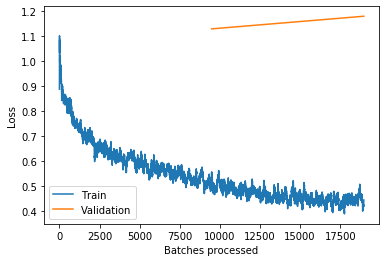

In [17]:
learn.recorder.plot_losses()

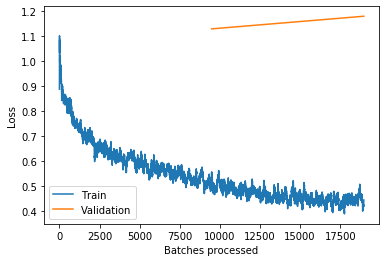

In [18]:
fig = learn.recorder.plot_losses(return_fig=True)
fig.savefig("loss_plot-stage5-2epochs-384_512-rescaled.png")

### Load model and investigate results

In [10]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage5-2epochs-384_512-rescaled");

In [12]:
# wandb.init(project="gabon")

W&B Run: https://app.wandb.ai/jedrzej/gabon/runs/39mr90sv

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

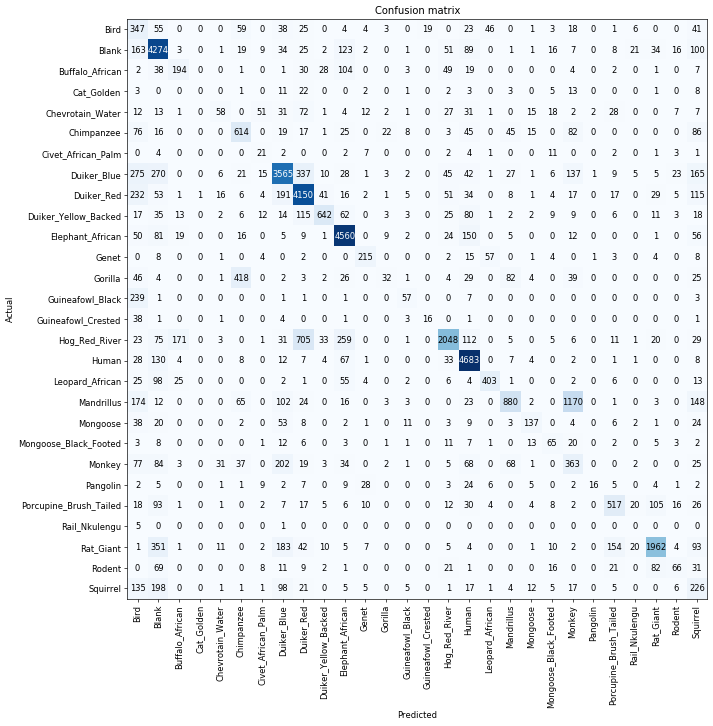

In [12]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [13]:
conf_m = interp.confusion_matrix()

In [14]:
len(conf_m)

28

In [15]:
correct_p = sum([conf_m[i,i] for i in range(len(conf_m))])
correct_p

30111

In [16]:
all_p = conf_m.sum().sum()
all_p

43628

In [17]:
print(f"accuracy is: {round(100 * correct_p / all_p,2)}%")

accuracy is: 69.02%


In [18]:
np.save("conf_m-stage5-2epochs-384_512-rescaled.npy", conf_m)

In [4]:
# conf_m = np.load("conf_m-stage5-2epochs-384_512-rescaled.npy")

## Rearrange columns

In [19]:
new_order = ['Blank',
             
             'Bird',
             'Guineafowl_Black',
             'Guineafowl_Crested',
             'Rail_Nkulengu',
              
             'Chevrotain_Water',
             'Duiker_Blue',
             'Duiker_Red',
             'Duiker_Yellow_Backed',
             
             'Chimpanzee',
             'Gorilla',
             'Mandrillus',
             'Monkey',
             
             'Civet_African_Palm',
             'Genet',
             'Mongoose',
             'Mongoose_Black_Footed',
             
             'Porcupine_Brush_Tailed',
             'Rat_Giant',
             'Rodent',
             
             'Buffalo_African',
             
             'Elephant_African',
             
             'Hog_Red_River',
             
             'Human',
             
             'Leopard_African',
             'Cat_Golden',
             
             'Pangolin',
             
             'Squirrel']

In [20]:
# np.save("new_order.npy", new_order)

In [32]:
# def plot_conf_matrix(conf_m, old_order, new_order, save_as=None):
#     df_conf_m = pd.DataFrame(conf_m, index=old_order, columns=old_order)
    
#     new_df_conf_m = df_conf_m.copy()
#     new_df_conf_m.columns = new_order
#     new_df_conf_m.index = new_order
    
#     for i_species in new_order:
#         for j_species in new_order:
#             new_df_conf_m.loc[i_species, j_species] = df_conf_m.loc[i_species, j_species]
    
#     plt.figure(figsize = (12,12))
#     ax = sns.heatmap(new_df_conf_m, annot=True, cmap=sns.color_palette("Blues", n_colors=10), cbar=False, fmt="d")
#     bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
    
#     if save_as:
#         plt.savefig(save_as)

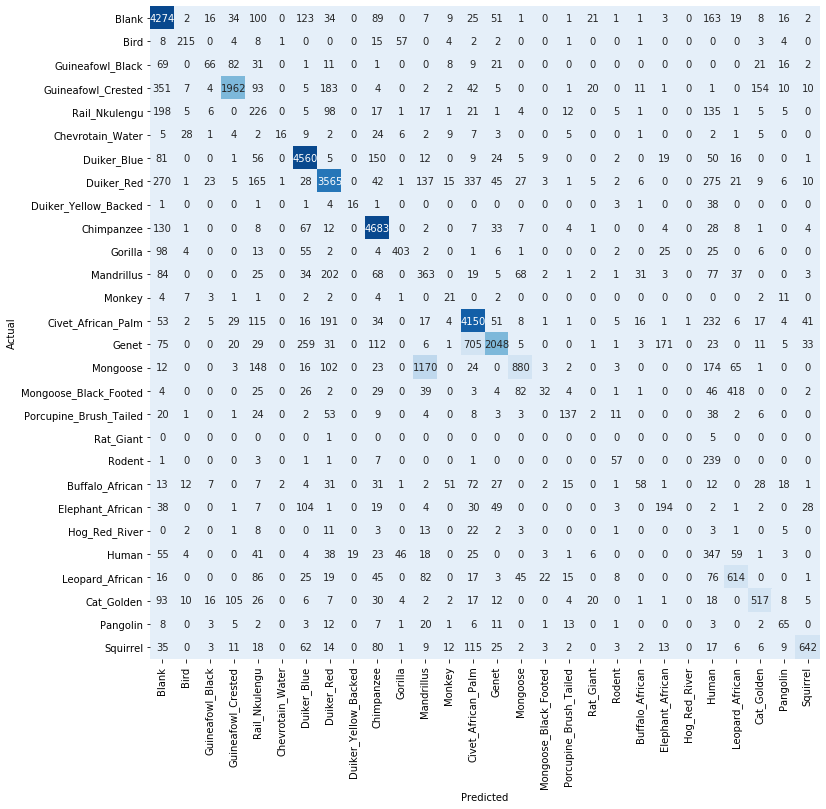

In [21]:
new_order = np.load("new_order.npy")
plot_conf_matrix(conf_m, classes, new_order, save_as="conf_m-new_order-stage5-2epochs-384_512-rescaled.png")